# TD1 - KPPV et réseaux de neurones pour la classification d'images

**Paul Flagel - Nathan Etourneau**

L'objectif de ce TP est d'implémenter un classifieur d'images au moyen de deux méthodes : les K Plus Proches Voisins (KPPV) et un réseau de neurones.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

# 0. Dataset utilisé pour la classification

Nous utiliserons la base d'images CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html) constituée de 60 000 images en couleur de taille 32x32 pixels, réparties en 10 classes (avion, voiture, oiseau, chat...). Le fichier est constitué de 5 batchs de 10000 images, et d'un batch de test de 10000 images.

Nous implémentons les fonctions nécessaires à leur extraction

In [51]:
path = "./cifar-10-python/cifar-10-batches-py"

def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict
    # Clés : [b'batch_label', b'labels', b'data', b'filenames']
    

def lecture_cifar(path: str, nb_batches):
    X = np.zeros(((nb_batches + 1) * 10000, 3072))
    Y = np.zeros(((nb_batches + 1) * 10000))
    for i in range(1, nb_batches + 1):
        batch_path = f"{path}/data_batch_{str(i)}"
        new_dict = unpickle(batch_path)
        batch_array = new_dict[b"data"]
        batch_labels = new_dict[b"labels"]
        X[(i - 1) * 10000 : i * 10000, :] = batch_array
        Y[(i - 1) * 10000 : i * 10000] = batch_labels

    new_dict = unpickle(f"{path}/test_batch")
    batch_array = new_dict[b"data"]
    batch_labels = new_dict[b"labels"]
    X[nb_batches * 10000 : (nb_batches + 1) * 10000, :] = batch_array
    Y[nb_batches * 10000 : (nb_batches + 1) * 10000] = batch_labels

    X = np.float32(X)
    Y = Y.astype(int)

    return X, Y

Ici, nous avons extrait les images dans des vecteurs de taille M = 32x32x3 = 3072, et nous les avons placées dans une matrice X de taille NxM avec N = 60 000. Nous retournons également un vecteur Y de taille Nx1 contenant le label de la classe de chaque image.

Nous implémentons maintenant une fonction permettant de découper les données en un set d'entraînement et un set de test. Nous avons la possibilité de choisir le ratio `taille_entrainement/taille_totale` et le booléen `small_sample` peut être passé à `True` pour ne prendre qu'un sous ensemble des images totales (permettant de prototyper plus rapidement les algorithmes).

In [52]:
def decoupage_donnees(X, Y, ratio=0.8, small_sample=False):
    N = X.shape[0]
    indices = np.array(range(N))
    np.random.shuffle(indices)

    if small_sample:
        X_train = X[indices[:500], :]
        Y_train = Y[indices[:500]]

        X_test = X[indices[-100:], :]
        Y_test = Y[indices[-100:]]

        return X_train, Y_train, X_test, Y_test

    M = int(ratio * N)
    X_train = X[indices[:M], :]
    Y_train = Y[indices[:M]]

    X_test = X[indices[M:], :]
    Y_test = Y[indices[M:]]

    return X_train, Y_train, X_test, Y_test

Nous extrayons les images et nous les découpons en allouant 80% des images à l'entrainement et 20% au test.

In [53]:
label_dict = unpickle(f"{path}/batches.meta")
label_names = label_dict[b"label_names"]

X, Y = lecture_cifar(path=path, nb_batches=5)
X_train, Y_train, X_test, Y_test = decoupage_donnees(
    X, Y, ratio=0.8, small_sample=True
)

print(f"LABELS : {label_names}")
print(f"Dim X : {X.shape}")
print(f"Dim Y : {Y.shape}")

LABELS : [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
Dim X : (60000, 3072)
Dim Y : (60000,)


**Visualisation des images**

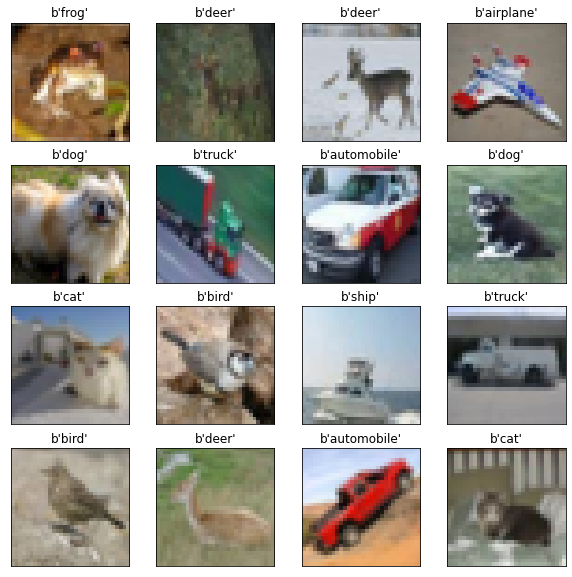

In [143]:
data_batch_1 = unpickle(f"{path}/data_batch_1")
imageId = [10*i for i in range(16)]
images = data_batch_1[b'data']
images = images[imageId]
labels = [data_batch_1[b'labels'][i] for i in imageId]

def visualisation_images(images, labels, gray=False):
    if gray:
        images = images.reshape(len(images),32,32)
    else:
        images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)
    rows, columns = 4, 4

    # define figure
    fig=plt.figure(figsize=(10, 10))
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if gray:
            plt.imshow(images[i-1], cmap="gray")
        else:
            plt.imshow(images[i-1])
        plt.xticks([])
        plt.yticks([])
        plt.title("{}".format(label_names[labels[i-1]]))
    plt.show()
    
visualisation_images(images, labels)

# 1. KPPV

In [55]:
X, Y = lecture_cifar(path=path, nb_batches=5)
X_train, Y_train, X_test, Y_test = decoupage_donnees(
    X, Y, ratio=0.8, small_sample=False
)

## 1.1 Développement du classifieur

### Calcul de la matrice de distances

Nous écrivons une fonction `kppv_distances` prenant en argument X_test et X_train et renvoyant la matrice des distances entre toutes les données de l'ensemble de test par rapport à toutes les données de l'ensemble d'apprentissage. La distance euclidienne L2 sera utilisée pour évaluer la distance entre les données.

Nous exploitons la vectorisation permise par le module numpy pour le calcul matriciel.

In [56]:
def kppv_distances(X_train, X_test):
    A_2 = (X_test ** 2).sum(axis=1).reshape((-1, 1))
    B_2 = (X_train ** 2).sum(axis=1).reshape((1, -1))
    dot_matrix = 2 * X_test.dot(X_train.T)
    distance_matrix = A_2 + B_2 - dot_matrix
    return distance_matrix

Cette matrice de dimension `len(X_test) x len(X_train)`

### Prédiction d'un élément

Pour prédire la classe d'un élément du set de test, nous cherchons, parmi tous les exemples d'entrainement les `K` ayant la distance la plus proche. Nous enregistrons les prédictions dans un vecteur `Y_pred` que nous allons ensuite comparer au vecteur `Y_test`.

In [57]:
def kppv_predict(distance_matrix, K, Y_train):
    N = distance_matrix.shape[0]
    Y_pred = np.zeros(N, dtype=int)
    for test_index in range(N):
        classes_kppv = Y_train[
            distance_matrix[test_index, :].argsort()[:K]
        ]
        Y_pred[test_index] = np.argmax(np.bincount(classes_kppv))
    return np.array(Y_pred)

In [58]:
K = 10
distance_matrix = kppv_distances(X_train, X_test)
Y_pred = kppv_predict(distance_matrix, K, Y_train)

In [59]:
def evaluation_classifieur(Y_pred,Y_test):
    return np.sum(Y_test == Y_pred) / len(Y_test)

In [63]:
accuracy = evaluation_classifieur(Y_pred, Y_test)

print(f"Accuracy : {accuracy}% for {K} classes")

Accuracy : 0.33508333333333334% for 10 classes


## 1.2 Expérimentations

### Influence du nombre de voisins K

Computing 1 neighbors
1 neighbors done

Computing 2 neighbors
2 neighbors done

Computing 3 neighbors
3 neighbors done

Computing 4 neighbors
4 neighbors done

Computing 5 neighbors
5 neighbors done

Computing 6 neighbors
6 neighbors done

Computing 7 neighbors
7 neighbors done

Computing 8 neighbors
8 neighbors done

Computing 9 neighbors
9 neighbors done

Computing 10 neighbors
10 neighbors done

Computing 11 neighbors
11 neighbors done

Computing 12 neighbors
12 neighbors done

Computing 13 neighbors
13 neighbors done

Computing 14 neighbors
14 neighbors done



Text(0, 0.5, 'Accuracy')

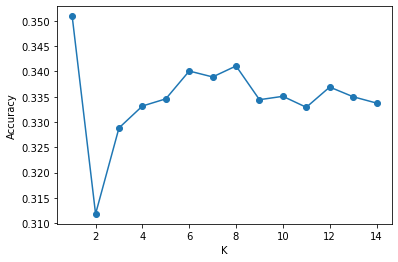

In [70]:
accuracy_list = []
x = range(1,15)
for K in x:
    print(f"Computing {K} neighbors")
    distance_matrix = kppv_distances(X_train, X_test)
    Y_pred = kppv_predict(distance_matrix, K, Y_train)
    accuracy_list.append(evaluation_classifieur(Y_pred,Y_test))
    print(f"{K} neighbors done\n")
    
plt.plot(x, accuracy_list, "o-")
plt.xlabel("K")
plt.ylabel("Accuracy")

Nous obtenons donc une valeur optimale pour K=1 avec un taux de classification de 35,1%, pour un algorithme entraîné sur 80% du dataset complet. 

### Utilisation de descripteurs LBP (Local Binary Pattern)

Afin d'accélérer le calcul des KPPV, nous utilisons des descripteurs des images. L'objectif est de réduire la taille des éléments à comparer afin de réduire la mémoire utilisée lors du calcul.

Nous utilisons ici des descripteurs LBP (après conversion des images en RGB). L'idée est, pour chaque pixel, de regarder les 8 pixels du voisinage et d'observer lesquels ont une valeur supérieure ou inférieure au pixel central. Nous attribuons au pixel central une valeur dépendant des pixels alentours et comptons la fréquence de ces valeurs (ici entre 0 et 9 dans l'implémentation scikit-image où nous avons choisi une méthode de calcul du pattern invariante par rotation `uniform`).

Ces valeurs entre 0 et 9 sont ensuite placées dans un histogramme de 10 bins constituant la description de l'image. Nous avons donc réduit la taille de nos données de 3072 à 10.

In [155]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

def convert_to_LBP(X):
    method = 'uniform'
    radius = 1
    nb_points = 8 * radius
    X_hist = []
    X_lbp = []
    X_gray = []
    for x in X:
        #convert to gray
        R = x[0:1024].reshape(32,32)
        G = x[1024:2048].reshape(32,32)
        B = x[2048:].reshape(32,32)
        img = np.dstack((R,G,B))
        grayscale = rgb2gray(img)
        X_gray.append(grayscale)
        
        lbp = local_binary_pattern(grayscale, nb_points, radius, method)  
        his, _ = np.histogram(lbp,normed=True, bins=nb_points+2, range=(0, nb_points+2))
        X_hist.append(his)
        X_lbp.append(lbp)
    return np.array(X_hist), np.array(X_lbp), np.array(X_gray)

X_train_hist, X_train_lbp, X_train_gray = convert_to_LBP(X_train)
X_test_hist, X_test_lbp, X_test_gray = convert_to_LBP(X_test)

/var/folders/rx/rfnf3b4d7l5_2w7ptp3y3_740000gn/T/ipykernel_32501/404480455.py:20: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  his, _ = np.histogram(lbp,normed=True, bins=nb_points+2, range=(0, nb_points+2))


In [199]:
X_test_hist.shape

(12000, 10)

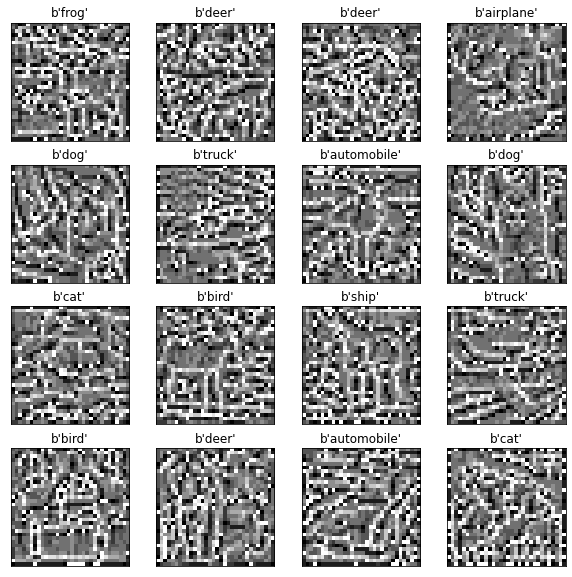

In [152]:
visualisation_images(X_lbp[imageId],labels, gray=True)

Computing 1 neighbors
1 neighbors done

Computing 2 neighbors
2 neighbors done

Computing 3 neighbors
3 neighbors done

Computing 4 neighbors
4 neighbors done

Computing 5 neighbors
5 neighbors done

Computing 6 neighbors
6 neighbors done

Computing 7 neighbors
7 neighbors done

Computing 8 neighbors
8 neighbors done

Computing 9 neighbors
9 neighbors done

Computing 10 neighbors
10 neighbors done

Computing 11 neighbors
11 neighbors done

Computing 12 neighbors
12 neighbors done

Computing 13 neighbors
13 neighbors done

Computing 14 neighbors
14 neighbors done

Computing 15 neighbors
15 neighbors done

Computing 16 neighbors
16 neighbors done

Computing 17 neighbors
17 neighbors done

Computing 18 neighbors
18 neighbors done

Computing 19 neighbors
19 neighbors done

Computing 20 neighbors
20 neighbors done

Computing 21 neighbors
21 neighbors done

Computing 22 neighbors
22 neighbors done

Computing 23 neighbors
23 neighbors done

Computing 24 neighbors
24 neighbors done

Computing 

Text(0, 0.5, 'Accuracy')

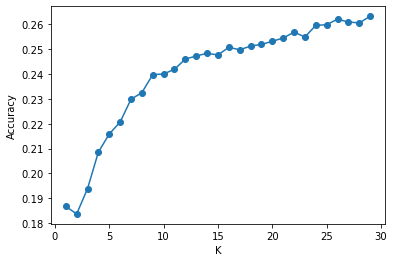

In [177]:
accuracy_list = []
x = range(1,30)
for K in x:
    print(f"Computing {K} neighbors")
    distance_matrix = kppv_distances(X_train_hist, X_test_hist)
    Y_pred = kppv_predict(distance_matrix, K, Y_train)
    accuracy_list.append(evaluation_classifieur(Y_pred,Y_test))
    print(f"{K} neighbors done\n")
    
plt.plot(x, accuracy_list, "o-")
plt.xlabel("K")
plt.ylabel("Accuracy")

Computing 1 neighbors
1 neighbors done

Computing 51 neighbors
51 neighbors done

Computing 101 neighbors
101 neighbors done

Computing 151 neighbors
151 neighbors done

Computing 201 neighbors
201 neighbors done

Computing 251 neighbors
251 neighbors done

Computing 301 neighbors
301 neighbors done

Computing 351 neighbors
351 neighbors done

Computing 401 neighbors
401 neighbors done

Computing 451 neighbors
451 neighbors done

Computing 501 neighbors
501 neighbors done



Text(0, 0.5, 'Accuracy')

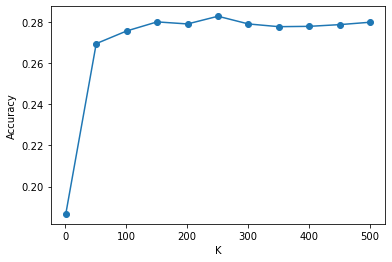

In [200]:
accuracy_list = []
x = range(1,502,50)
for K in x:
    print(f"Computing {K} neighbors")
    distance_matrix = kppv_distances(X_train_hist, X_test_hist)
    Y_pred = kppv_predict(distance_matrix, K, Y_train)
    accuracy_list.append(evaluation_classifieur(Y_pred,Y_test))
    print(f"{K} neighbors done\n")
    
plt.plot(x, accuracy_list, "o-")
plt.xlabel("K")
plt.ylabel("Accuracy")

Nous observons, en entraînant l'algorithme sur les descripteurs LBP, que le K optimal augmente énormément, avec le taux de classification qui atteint un maximum à 29% pour environ K = 250.

Nous trouvons que cette valeur est trop élevée vu la qualité des images et la simplicité des opérations que nous effectuons dessus (norme L2). Cela est donc probablement dû à la réduction trop importante du nombre de features des images.

### Utilisation de descripteurs HOG (Histograms of Oriented Gradients)

Nous allons désormais utiliser les descripteurs HOG pour représenter les images. Cela consiste à calculer pour chaque pixel le gradient local, au moyen des pixels présents autour. Pour cela, nous calculons le gradient horizontal et vertical. dans des cellules constituées de plusieurs pixels de l'image. Pour chaque pixel de la cellule nous calculons l'orientation et la magnitude du gradient puis nous construisons un histogramme en plaçant la magnitude dans les bins correspondant à l'orientation.

Nous quadrillons ici l'image en 16 cellules où 8 orientations seront calculées. Nous devrions donc obtenir des descripteurs de taille 128.

In [203]:
from skimage.feature import hog

def convert_to_HOG(X):
    normalize = True                     
    block_norm = 'L2-Hys'     
    orientations = 8           
    pixels_per_cell = [8, 8]  
    cells_per_block = [1, 1]
    X_hog = []
    X_fd = []
    
    for x in X:
        R = x[0:1024].reshape(32,32)
        G = x[1024:2048].reshape(32,32)
        B = x[2048:].reshape(32,32)
        img = np.dstack((R,G,B))
        fd, hog_image = hog(img, orientations, pixels_per_cell,cells_per_block,block_norm, visualize=True,multichannel=True)
        X_hog.append(hog_image)
        X_fd.append(fd)
    return np.array(X_hog), np.array(X_fd)

X_train_hog_image, X_train_hog = convert_to_HOG(X_train)
X_test_hog_image, X_test_hog = convert_to_HOG(X_test)

In [240]:
X_train_hog[0].shape

(128,)

Nous avons obtenu des descripteurs de taille 128 au lieu de 3072. Nous devons désormais tester le taux de classification sur différentes valeurs de K pour un matrice de distance calculée sur les descripteurs.

#### Visualisation des HOG

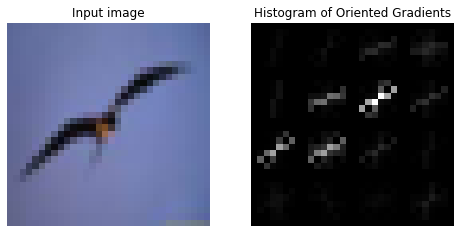

In [257]:
from skimage import exposure

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

input_image = X_train[22].reshape(3,32,32).transpose(1,2,0)/255

ax1.axis('off')
ax1.imshow(input_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(X_train_hog_image[0], in_range=(0, 10))

ax2.axis('off')
ax2.imshow(X_train_hog_image[22], cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

Computing 1 neighbors
1 neighbors done

Computing 3 neighbors
3 neighbors done

Computing 5 neighbors
5 neighbors done

Computing 7 neighbors
7 neighbors done

Computing 9 neighbors
9 neighbors done

Computing 11 neighbors
11 neighbors done

Computing 13 neighbors
13 neighbors done

Computing 15 neighbors
15 neighbors done

Computing 17 neighbors
17 neighbors done

Computing 19 neighbors
19 neighbors done

Computing 21 neighbors
21 neighbors done

Computing 23 neighbors
23 neighbors done

Computing 25 neighbors
25 neighbors done

Computing 27 neighbors
27 neighbors done

Computing 29 neighbors
29 neighbors done



Text(0, 0.5, 'Accuracy')

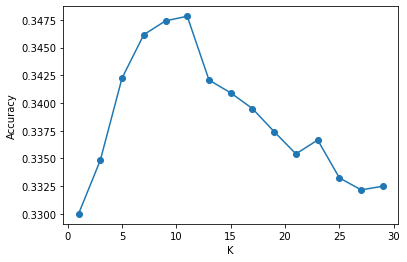

In [258]:
accuracy_list = []
x = range(1,30,2)
for K in x:
    print(f"Computing {K} neighbors")
    distance_matrix = kppv_distances(X_train_hog, X_test_hog)
    Y_pred = kppv_predict(distance_matrix, K, Y_train)
    accuracy_list.append(evaluation_classifieur(Y_pred,Y_test))
    print(f"{K} neighbors done\n")
    
plt.plot(x, accuracy_list, "o-")
plt.xlabel("K")
plt.ylabel("Accuracy")